In [1]:
!wget https://pjreddie.com/media/files/yolov3.weights
!git clone https://github.com/pjreddie/darknet.git

--2023-11-06 19:49:06--  https://pjreddie.com/media/files/yolov3.weights
Resolving pjreddie.com (pjreddie.com)... 128.208.4.108
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248007048 (237M) [application/octet-stream]
Saving to: ‘yolov3.weights’

yolov3.weights      100%[===================>] 236.52M  46.5MB/s    in 5.5s    

2023-11-06 19:49:12 (42.7 MB/s) - ‘yolov3.weights’ saved [248007048/248007048]

Cloning into 'darknet'...
remote: Enumerating objects: 5955, done.
remote: Total 5955 (delta 0), reused 0 (delta 0), pack-reused 5955
Receiving objects: 100% (5955/5955), 6.37 MiB | 14.83 MiB/s, done.
Resolving deltas: 100% (3931/3931), done.


# Recorded Road Video

In [3]:
import cv2
import numpy as np

In [ ]:
def load_yolo(weights_path, config_path, names_path):

  net = cv2.dnn.readNet(weights_path, config_path)
  with open(names_path, "r") as f:
    classes = f.read().strip().split("\n")
  return net, classes

def draw_bounding_boxes(image, boxes):

  for (class_name, confidence, (left, top, right, bottom)) in boxes:
    cv2.rectangle(image, (left, top), (right, bottom), (0, 255, 0), 7)
    text = "{} ({:.2f}%)".format(class_name, confidence * 100)
    cv2.putText(image, text, (left, top - 5), cv2.FONT_HERSHEY_SIMPLEX, 2, (0, 0, 255), 7)

In [ ]:
weights_path = "/content/yolov3.weights"
config_path = "/content/darknet/cfg/yolov3.cfg"
names_path = "/content/darknet/data/coco.names"

net, classes = load_yolo(weights_path, config_path, names_path)

image = cv2.imread("/content/Blog_cover-52-scaled.jpeg")

In [ ]:
def detect_objects(net, classes, image, confidence_threshold, nms_threshold):
    blob = cv2.dnn.blobFromImage(image, 1 / 255.0, (416, 416), swapRB=True, crop=False)
    net.setInput(blob)
    detections = net.forward(net.getUnconnectedOutLayersNames())

    boxes = []
    for detection in detections:
        for obj in detection:
            scores = obj[5:]
            class_id = np.argmax(scores)
            confidence = scores[class_id]
            if confidence > confidence_threshold:
                center_x, center_y, width, height = (obj[0:4] * np.array([image.shape[1], image.shape[0], image.shape[1], image.shape[0]])).astype(int)
                left = int(center_x - width / 2)
                top = int(center_y - height / 2)
                right = left + width
                bottom = top + height
                boxes.append((classes[class_id], confidence, (left, top, right, bottom)))
    boxes_dim = [box[2] for box in boxes]
    # Perform non-maximum suppression.
    confidences = [box[1] for box in boxes]
    indices = cv2.dnn.NMSBoxes(boxes_dim, confidences, confidence_threshold, nms_threshold)
    filtered_boxes = [boxes[i] for i in indices]

    return filtered_boxes

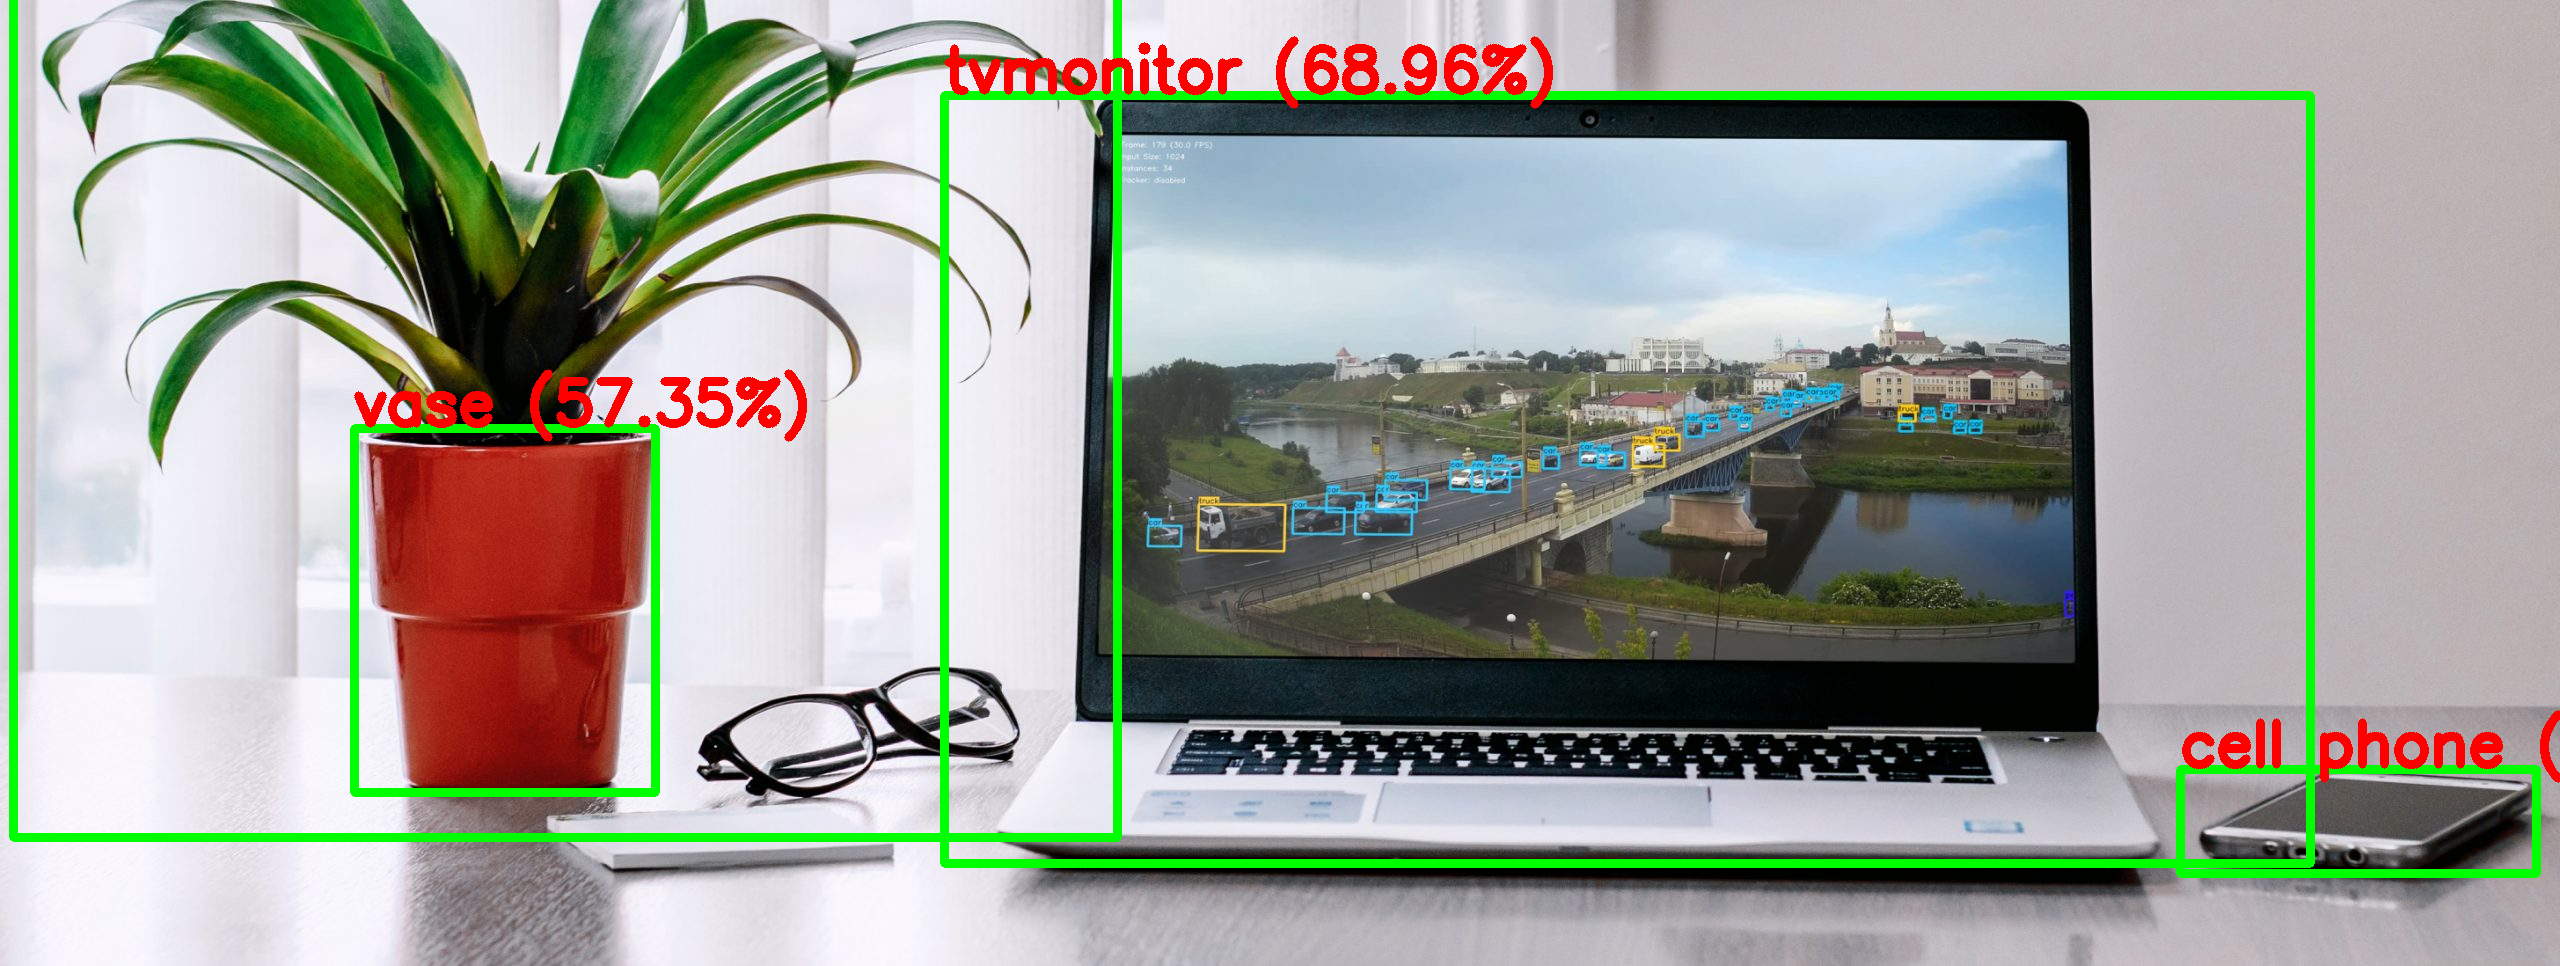

In [4]:
# Set the confidence threshold and NMS threshold.
confidence_threshold = 0.5
nms_threshold = 0.3

# Detect objects in the image.
boxes = detect_objects(net, classes, image, confidence_threshold, nms_threshold)

# Draw bounding boxes around the detected objects.
draw_bounding_boxes(image, boxes)

from google.colab.patches import cv2_imshow
cv2_imshow(image)

In [ ]:
# Define the output video writer
output_path = "output_video.mp4"
fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # Codec for MP4 format

# Load the video
video_path = "4K Road traffic video for object detection and tracking - free download now!.mp4"
cap = cv2.VideoCapture(video_path)
output_video = cv2.VideoWriter(output_path, fourcc, 7,(int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)), int(cap.get( cv2.CAP_PROP_FRAME_HEIGHT))))

# Set the start and end time for the 1-minute clip (in seconds)
start_time = 0  # Start from the beginning
end_time = 60   # 1 minute
i = 0
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    # Get the current frame's timestamp in seconds
    current_time = cap.get(cv2.CAP_PROP_POS_MSEC) / 1000
    print(current_time)
    if current_time >= start_time and current_time <= end_time:
        # Set the confidence threshold and NMS threshold.
        confidence_threshold = 0.5
        nms_threshold = 0.3

        # Detect objects in the image.
        boxes = detect_objects(net, classes, frame, confidence_threshold, nms_threshold)

        # Draw bounding boxes around the detected objects.
        draw_bounding_boxes(frame, boxes)

        # Write the frame with bounding boxes to the output video
        output_video.write(frame)
        cv2.imshow('Objdet', frame)

    if current_time > end_time:
        break

        # Check for a key press
    key = cv2.waitKey(1) & 0xFF

    # Press 'q' to exit the loop and close the window
    if key == ord('q'):
        break

# Release the video capture and writer
cap.release()
output_video.release()
cv2.destroyAllWindows()

# Live Video

In [ ]:
import cv2

weights_path = "yolov3 (1).weights"
config_path = "darknet/cfg/yolov3.cfg"
names_path = "darknet/data/coco.names"

net, classes = load_yolo(weights_path, config_path, names_path)

cap = cv2.VideoCapture(0)

while True:
    ret, frame = cap.read()

    if not ret:
        print("Failed to capture frame.")
        break
    confidence_threshold = 0.5
    nms_threshold = 0.3

        # Detect objects in the image.
    boxes = detect_objects(net, classes, frame, confidence_threshold, nms_threshold)
    # Draw bounding boxes around the detected objects.
    draw_bounding_boxes(frame, boxes)
    # Perform your image processing on the 'frame' here

    cv2.imshow("Live Video", frame)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()